In [6]:
import torch
import botorch
from math import sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.autograd.functional import hvp, hessian

In [7]:
def w(x, L=5, eps=0.01):
    a = (L + 1) * eps ** 0.5
    b = 3 * L + 1
    x = torch.abs(x)
    return torch.where(x <= eps ** 0.5, -eps ** 0.5 * x ** 2 + x ** 3 / 3,
                       torch.where(x <= L * eps ** 0.5, -eps * x + eps ** 1.5 / 3,
                                   eps ** 0.5 * (x - a) ** 2 + (x - a) ** 3 / 3 - b * eps ** 1.5 / 3))
def E(x):
    return w(x[0]) + 10 * x[1] ** 2

In [8]:
def f(x, y):
    return E(torch.tensor([x, y]))

Loss: -0.005330: 100%|██████████| 400000/400000 [01:43<00:00, 3872.95it/s]


(-0.006, 0.001)

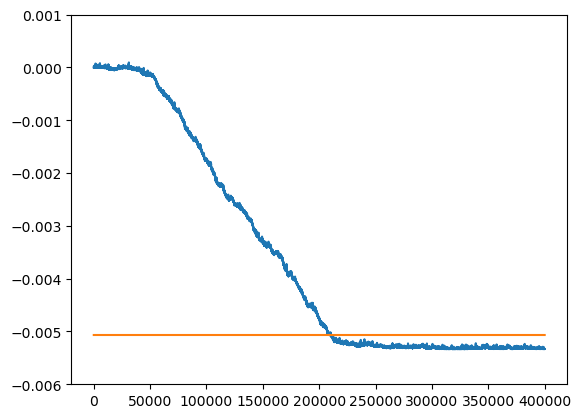

In [15]:
torch.manual_seed(598)
# x = torch.rand(2, requires_grad=True, device='cuda')
x = torch.zeros(2, requires_grad=True)
func_name = "f1"
func = {
    "name": "f1",
    "function": E,
    "l": 0.1,
    "rho": 1,
    "minimal": -19/3750
}

start=x
epochs=4e5
lr=3e-4
batch_size=10
epochs = int(epochs)
f = func['function']
optimizer = torch.optim.SGD([x], lr=lr)
loss_list = []
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        optimizer.zero_grad()
        loss = f(x)
        loss.backward()
        x.grad = x.grad + torch.randn_like(x) / sqrt(batch_size)
        loss_list.append(loss.item())
        optimizer.step()
        if (i + 1) % 1000 == 0:
            pbar.set_description(f"Loss: {loss:5f}")
        pbar.update(1)
np.save(f"{func['name']}_{lr}_{epochs}epoch.npy", np.array(loss_list))
    
ax = plt.gca()
ax.plot(range(epochs), loss_list)
ax.plot(range(epochs), [func['minimal']] * epochs)
ax.set_ylim([-0.006, 0.001])

In [17]:
class cubic(torch.optim.Optimizer):
    def __init__(self, params, f, eps=0.01, l=5, rho=1):
        super(cubic, self).__init__(params, defaults={})
        self.f = f
        self.x = params[0]
        self.eps = eps
        self.l = l
        self.rho = rho
        self.stop = False
        self.deltam_list = []
    
    def finalsolver(self, g):
        delta = torch.zeros_like(g)
        gm = g
        eta = 0.05 / self.l
        while gm.norm() > self.eps / 2:
            delta = delta - eta * gm
            gm = g + hvp(self.f, self.x, delta)[1] + self.rho / 2 * delta.norm() * delta
        return delta
    
    def subsolver(self, g):
        if g.norm() >= self.l ** 2 / self.rho:
            a = g @ hvp(self.f, self.x, g)[1] / self.rho / g.norm() ** 2
            rc = -a + torch.sqrt(a ** 2 + 2 * g.norm() / self.rho)
            delta = -rc * g / g.norm()
        else:
            delta = torch.zeros_like(g)
            # sigma = 1e-5 * sqrt(self.eps * self.rho) / self.l
            sigma = 0.01
            eta = 0.05 / self.l
            xi = botorch.utils.sampling.sample_hypersphere(g.shape[0]).reshape(-1)
            gtil = g + sigma * xi
            for _ in range(10):
                delta -= eta * (gtil + hvp(self.f, self.x, delta)[1] + self.rho / 2 * delta.norm() * delta)
        deltam = g @ delta + 0.5 * delta @ hvp(self.f, self.x, delta)[1] + self.rho / 6 * delta.norm() ** 3
        return delta, deltam
    
    def step(self):
        gt = self.x.grad.data
        delta, deltam = self.subsolver(gt)
        # if deltam >= -0.01 * sqrt(self.eps ** 3 / self.rho):
        #     delta = self.finalsolver(gt)
            # self.stop = True
        self.x.data += delta
        self.deltam_list.append(deltam)

In [40]:
torch.manual_seed(1)
# x = torch.rand(2, requires_grad=True, device='cuda')
x = torch.zeros(2, requires_grad=True)
batch_size = 256
optimizer = cubic([x], E, eps=0.01, l=20, rho=1)
loss_list2 = []
x_list = []
epochs = 15265
for i in tqdm(range(epochs)):
    optimizer.zero_grad()
    loss = E(x)
    loss.backward()
    x.grad = x.grad + torch.randn_like(x) / sqrt(batch_size)
    # x.grad = x.grad
    loss_list2.append(loss.item())
    optimizer.step()
    x_list.append(x.tolist())
    if optimizer.stop:
        break

100%|██████████| 15265/15265 [01:56<00:00, 131.20it/s]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

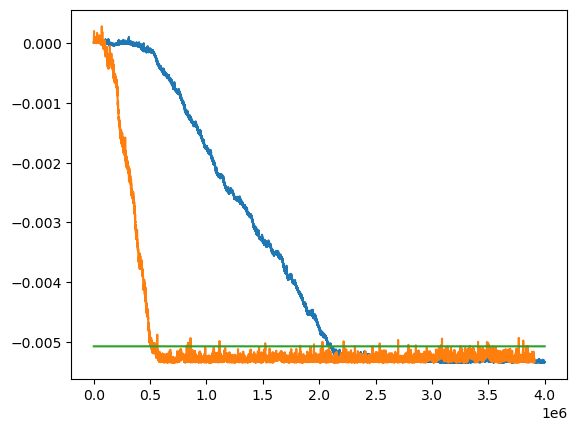

In [50]:
ax.plot(np.arange(4e5)*10, loss_list)
ax.plot(np.arange(len(loss_list2)) * batch_size, loss_list2)
ax.plot(np.arange(4e5)*10, [func['minimal']] * 400000)
# ax.plot(np.arange(len(loss_list2)) * batch_size, [func['minimal']] * len(loss_list2))
ax.set_ylim([-0.006, 0.001])
ax.legend(['SGD', 'Stochastic Cubic Regularization', 'Minimal'])
plt.savefig('plot1', ax)

(-0.0001, 0.0001)

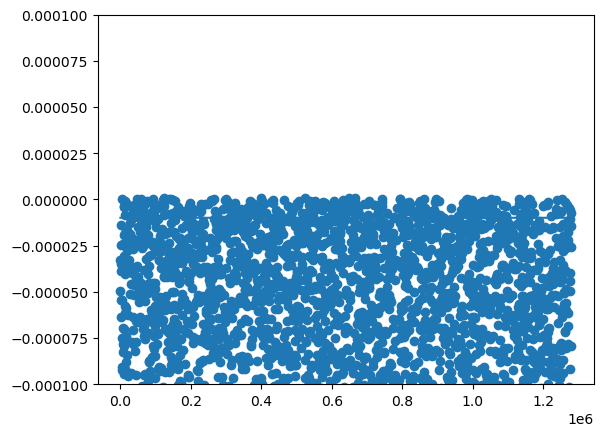

In [68]:
ax = plt.gca()
ax.scatter(np.arange(len(loss_list)) * batch_size, optimizer.deltam_list)
ax.plot(np.arange(len(loss_list)) * batch_size, [-1e-5] * len(loss_list))
ax.set_ylim([-0.0001, 0.0001])